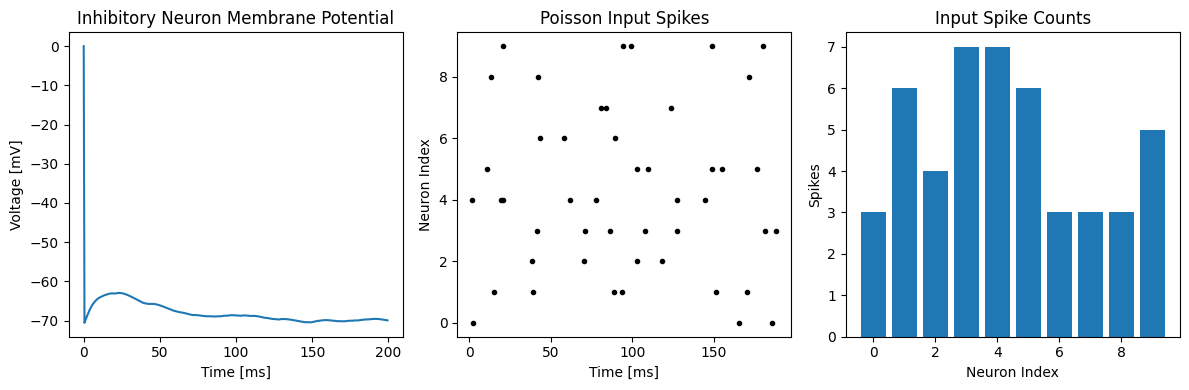

In [9]:
# The user has provided a full set of Brian2 equations and synapse definitions for a network.
# To verify and simulate a simplified version of this network, I will define a basic working test version here.

from brian2 import *
import matplotlib.pyplot as plt
import numpy as np  # if not already imported

# Constants and shared parameters
defaultclock.dt = 500*us

# Network sizes (reduced for quick test)
N_post_inh = 1
N_post_ex = 1
N_inputs = 10

# Example parameter values (simplified)
g_L = 30 * nS
V_rest = -70.6 * mV
V_T = -50.4 * mV
delta_T = 2 * mV
C = 281 * pF
a = 4 * nS
b = 0.0805 * nA
I_sp = 400 * pA
tau_w = 144 * ms
tau_z = 40 * ms
V_Th_rest = -50.4 * mV
V_Th_max = -30.4 * mV
tau_V_Th = 50 * ms
tau_syn_inh = 10 * ms
tau_syn_ex = 10 * ms
tau_x = 15 * ms
x_reset = 1.0
tau_LTD = 20 * ms
tau_LTP = 20 * ms
tau_homeo = 100 * ms
theta_LTD = -60 * mV
theta_LTP = -45 * mV
A_LTD = 1e-5
A_LTP = 5e-5
u_sq_ref = 1 * mV**2

# Neuron equations
eqs_neuron_inh = """
dv/dt = (g_L*(V_rest - v) + delta_T*g_L*exp((v - V_T)/delta_T) + I + I_syn - w + z)/C : volt
dw/dt = (a*(v - V_rest) - w)/tau_w : amp
dz/dt = -z/tau_z : amp
dV_T/dt = (-(V_T - V_Th_rest))/tau_V_Th : volt
I : amp
dI_syn/dt = -I_syn/tau_syn_inh : amp
"""

eqs_neuron_ex = """
dv/dt = (g_L*(V_rest - v) + delta_T*g_L*exp((v - V_T)/delta_T) + I + I_syn - w + z)/C : volt
dw/dt = (a*(v - V_rest) - w)/tau_w : amp
dz/dt = -z/tau_z : amp
dV_T/dt = (-(V_T - V_Th_rest))/tau_V_Th : volt
dv_LTD/dt = (v - v_LTD)/tau_LTD : volt
dv_LTP/dt = (v - v_LTP)/tau_LTP : volt
dv_homeo/dt = (v - V_rest - v_homeo)/tau_homeo : volt
I : amp
dI_syn/dt = -I_syn/tau_syn_ex : amp
dx_trace/dt = -x_trace/tau_x + X_sp/tau_x : 1
X_sp : 1
"""

eqs_inputs_Poisson = """
rates : Hz
dx_trace/dt = -x_trace/tau_x : 1
selected_index : integer (shared)
"""

# Create neurons
neuron_inh = NeuronGroup(N_post_inh, eqs_neuron_inh,
                         threshold='v > V_Th_max',
                         reset='v = V_rest; V_T = V_Th_max; w += b; z += I_sp',
                         method='euler')
neuron_ex = NeuronGroup(N_post_ex, eqs_neuron_ex,
                        threshold='v > V_Th_max',
                        reset='v = V_rest; V_T = V_Th_max; x_trace += x_reset/(tau_x/ms); w += b; z += I_sp',
                        method='euler')
neurons_input_Poisson = NeuronGroup(N_inputs, eqs_inputs_Poisson,
                                    threshold='rand() < rates * dt',
                                    method='euler')

# Initialize parameters
neurons_input_Poisson.rates = 20 * Hz
neurons_input_Poisson.selected_index = 5

# Define connection (simplified, using same index for test)
x_pre_p = list(range(N_inputs))
y_post_inh = [0]*N_inputs

Syn_inh = Synapses(neurons_input_Poisson, neuron_inh, 'weight : 1',
                   on_pre='I_syn += weight * rates_pre * pA * second')
Syn_inh.connect(i=x_pre_p, j=y_post_inh)
Syn_inh.weight = 1.0

# Monitors
mon_inh = StateMonitor(neuron_inh, 'v', record=True)
mon_input = SpikeMonitor(neurons_input_Poisson)

# Run simulation
run(200*ms)

mon_inh.v[0][:10], mon_input.t[:10], mon_input.i[:10]

# Plot membrane potential trace
plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.plot(mon_inh.t/ms, mon_inh.v[0]/mV)
plt.title("Inhibitory Neuron Membrane Potential")
plt.xlabel("Time [ms]")
plt.ylabel("Voltage [mV]")

# Plot Poisson input spike raster
plt.subplot(132)
plt.plot(mon_input.t/ms, mon_input.i, '.k')
plt.title("Poisson Input Spikes")
plt.xlabel("Time [ms]")
plt.ylabel("Neuron Index")

# Histogram of input neuron activity
plt.subplot(133)
plt.hist(mon_input.i, bins=np.arange(-0.5, N_inputs + 0.5, 1), rwidth=0.8)
plt.title("Input Spike Counts")
plt.xlabel("Neuron Index")
plt.ylabel("Spikes")

plt.tight_layout()
plt.show()